## 0. Install pkgs for TWCC

In [ ]:
#!sh install_env.sh

## 1. Download dataset

In [2]:
from datetime import datetime

import tensorflow as tf
from tensorboard.plugins import projector

# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import cv2
import vlogging


print("tf version : ", tf.__version__)

# 下載資料,(flower ~218MB)
# keras下載位置預設為~/user/.keras/datasets/
# !ls /Users/lsw/.keras/datasets/flower_photos
# LICENSE.txt daisy  dandelion  roses  sunflowers  tulips

# flood
# origin = 'https://drive.narlabs.org.tw/webrelay/directdownload/txp8hb31v67tl47f/?dis=10014&fi=2683826'
# data_dir = tf.keras.utils.get_file(origin=origin, fname='floods', untar=True)

# flowers
# origin = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
# data_dir = tf.keras.utils.get_file(origin=origin, fname='flower_photos', untar=True)
# data_dir = '/home/u3148947/.keras/datasets/flower_photos' #不下載，直接sftp上傳

# uni
data_dir = '/home/u3148947/.keras/datasets/uni' #不下載，直接sftp上傳

data_dir = pathlib.Path(data_dir) # 注意！這把原本路徑轉換成PosixPath的物件=PosixPath('~/user/.keras/datasets/')不是原始的string路徑。
image_count = len(list(data_dir.glob('*/*.jpg')))
#CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" and not item.name.startswith('.')])
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))

# todo:這裡可以幫學員回憶python強大的表示式處理


# data information
print("Save to :", data_dir)
print("Count images: ", image_count)
print("Class names : ", class_names)
print("Class number: ", len(class_names))

tf version :  2.2.0
Save to : /home/u3148947/.keras/datasets/uni
Count images:  5620
Class names :  ['ng' 'ok']
Class number:  2


In [3]:
# 檢查資料夾內圖片

roses = list(data_dir.glob('sunflowers/*'))

for image_path in roses[:2]:
    display.display(Image.open(str(image_path)))

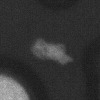

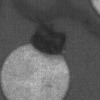

In [4]:
# 檢查資料夾內圖片

roses = list(data_dir.glob('ng/*'))

for image_path in roses[:2]:
    display.display(Image.open(str(image_path)))

In [5]:
# vars
BATCH_SIZE = 32 #32 
img_height = 100 #100
img_width = 100 #100
# STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

#IMG_SIZE = (224, 224) # IMG_SIZE = (160, 160)

## 2. Load dataset with tf.data


In [6]:
# 以tf.data來讀取資料
# 同樣地，給定本地資料集的路徑。
# 2020-06-11版本(相同)
"""tf.data.Dataset.list_files
Note: The default behavior of this method is to return filenames in 
a non-deterministic random shuffled order. Pass a seed or shuffle=False 
to get results in a deterministic order.預設為random shuffle"""

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [7]:
# 檢查路徑、檔案

for f in list_ds.take(10):
  print(f.numpy())

b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI#6_19CC2018-01-000_2_NG003_Panel0020_ProcA3_Shot0_V24_D0_Img.jpg'
b'/home/u3148947/.keras/datasets/uni/ok/CSPAFI#6_19CC2018-05-000_1_NG009_Panel0017_ProcA3_Shot0_V12_D1_Img.jpg'
b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI#6_19CJ2028-02-000_1_NG002_Panel0008_ProcA3_Shot0_V2_D0_Img.jpg'
b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI#6_19CC2018-02-000_1_NG002_Panel0007_ProcA4_Shot0_V15_D0_Img.jpg'
b'/home/u3148947/.keras/datasets/uni/ok/CSPAFI#6_19CC2018-02-000_1_NG003_Panel0006_ProcA4_Shot0_V26_D1_Img.jpg'
b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI-C#3_19CC2018-04-000_1_NG008_Panel0022_ProcA3_Col#1_Shot0_V23_D2_Img.jpg'
b'/home/u3148947/.keras/datasets/uni/ok/CSPAFI#6_19CC2018-02-000_1_NG003_Panel0010_ProcA4_Shot0_V21_D0_Img.jpg'
b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI#6_19CC2018-02-000_1_NG006_Panel0002_ProcA4_Shot0_V7_D0_Img.jpg'
b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI-C#3_19CJ2027-02-000_1_NG016_Panel0006_ProcA4_Col#2_

hit: 觀察有無shuffle變化

In [8]:
#增加了對類別排序而已sorted ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']

class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['ng' 'ok']


hit: 這裏可以請同學練習list基本原理與操作，往後資料呈現都會是以多維list or array方式。

hit:列表產生式與產生器的不同，`[] and ()`使用差異。

### Split the dataset into train and validation:

In [9]:
# train 80, val 20
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)



In [10]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

4498
1124


In [11]:
for t,v in zip(train_ds.take(2),val_ds.take(2)):
  print(t.numpy(), '\n')
  print(v.numpy())


b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI#6_19CJ2028-02-000_1_NG008_Panel0019_ProcA3_Shot0_V16_D6_Img.jpg' 

b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI#6_19CC2018-01-000_2_NG003_Panel0020_ProcA3_Shot0_V24_D0_Img.jpg'
b'/home/u3148947/.keras/datasets/uni/ok/CSPAFI-C#3_19CJ2027-02-000_1_NG008_Panel0005_ProcA3_Col#1_Shot0_V13_D0_Img.jpg' 

b'/home/u3148947/.keras/datasets/uni/ok/CSPAFI#6_19CC2018-05-000_1_NG009_Panel0017_ProcA3_Shot0_V12_D1_Img.jpg'


In [12]:
#J Save train/val path list for later used

# len(list(val_ds))#1124 images for val_ds

count = 0
for element in val_ds.take(2):
    print(element) #tf.Tensor(b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI#6_19CC2018-05-000_1_NG011_Panel0006_ProcA3_Shot0_V5_D0_Img.jpg', shape=(), dtype=string)
    parts = tf.strings.split(element, os.path.sep)
    print('parts[] =', parts[-2]) # [-2]= dir name, [-1]= file name.
    count += 1   
print(count)
    

tf.Tensor(b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI#6_19CC2018-01-000_2_NG003_Panel0020_ProcA3_Shot0_V24_D0_Img.jpg', shape=(), dtype=string)
parts[] = tf.Tensor(b'ng', shape=(), dtype=string)
tf.Tensor(b'/home/u3148947/.keras/datasets/uni/ok/CSPAFI#6_19CC2018-05-000_1_NG009_Panel0017_ProcA3_Shot0_V12_D1_Img.jpg', shape=(), dtype=string)
parts[] = tf.Tensor(b'ok', shape=(), dtype=string)
2


### Converts a file path to an (img, label) pair:

In [13]:
#J tf2.3新版load_data/images使用one-hot, 所以後面的training 要把sparse_categorical_crossentropy換掉，變傳統的one-hot/categorical loss.
#新版：tf2.3
#
#J modify the get_label for runing at tf2.2 2020-08-06 2020-08-11 OKfortf2.2
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num
#     return tf.argmax(one_hot)
#   return tf.math.argmax(one_hot)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label



# hit: 請學員參考寫註解(英文)的方式，清晰易讀。中文註解主要作為課程說明與程式註解用途不同。

In [14]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds_map = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds_map = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)



one_num: Tensor("ArgMax:0", shape=(), dtype=int64)
one_num: Tensor("ArgMax:0", shape=(), dtype=int64)


## 3. configure_for_performance_cache tf.data

In [15]:
#J
#新版：簡化很多
# def configure_for_performance(ds):
#   ds = ds.cache()
#   ds = ds.shuffle(buffer_size=1000)
#   ds = ds.batch(BATCH_SIZE)
#   ds = ds.prefetch(buffer_size=AUTOTUNE)
#   return ds

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

MULTI_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync

print('BATCH_SIZE: {}, MULTI_BATCH_SIZE: {}'.format(BATCH_SIZE, MULTI_BATCH_SIZE))

def configure_for_performance_cache(ds, cache=True):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
      print("Check cache to file:", cache)
    else:
      ds = ds.cache()
      print("Check cache in memory:", cache)
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
BATCH_SIZE: 32, MULTI_BATCH_SIZE: 32


hit:

    ds.shuffle(buffer_size=1000)
    表示buffer維持一千張圖，隨機抽掉一張後，會由1001張補進維持1K張。因此完美的洗牌建議buffer要大於或等於dataset數量。

In [16]:
#J 新版：
train_ds_pre = configure_for_performance_cache(train_ds_map)
val_ds_pre = configure_for_performance_cache(val_ds_map)


Check cache in memory: True
Check cache in memory: True


### Visualize the data
You can visualize this dataset similarly to the one you created previously.

label from label_batch: tf.Tensor(1, shape=(), dtype=int64)
label from label_batch: tf.Tensor(0, shape=(), dtype=int64)
label from label_batch: tf.Tensor(0, shape=(), dtype=int64)
label from label_batch: tf.Tensor(0, shape=(), dtype=int64)
label from label_batch: tf.Tensor(0, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)
label from label_batch: tf.Tensor(0, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)


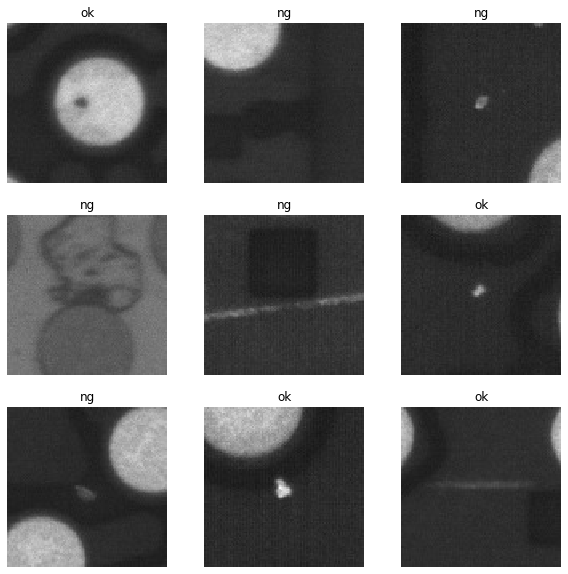

In [17]:
#J 新版：tf2.3

image_batch, label_batch = next(iter(train_ds_pre))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  print('label from label_batch:', label)
  plt.title(class_names[label])
  plt.axis("off")

In [18]:
image_batch[0].numpy()

array([[[140., 140., 140.],
        [129., 129., 129.],
        [115., 115., 115.],
        ...,
        [ 33.,  33.,  33.],
        [ 32.,  32.,  32.],
        [ 32.,  32.,  32.]],

       [[114., 114., 114.],
        [105., 105., 105.],
        [ 94.,  94.,  94.],
        ...,
        [ 34.,  34.,  34.],
        [ 34.,  34.,  34.],
        [ 34.,  34.,  34.]],

       [[ 97.,  97.,  97.],
        [ 89.,  89.,  89.],
        [ 76.,  76.,  76.],
        ...,
        [ 31.,  31.,  31.],
        [ 31.,  31.,  31.],
        [ 31.,  31.,  31.]],

       ...,

       [[167., 167., 167.],
        [156., 156., 156.],
        [140., 140., 140.],
        ...,
        [ 35.,  35.,  35.],
        [ 35.,  35.,  35.],
        [ 34.,  34.,  34.]],

       [[165., 165., 165.],
        [162., 162., 162.],
        [157., 157., 157.],
        ...,
        [ 36.,  36.,  36.],
        [ 35.,  35.,  35.],
        [ 35.,  35.,  35.]],

       [[161., 161., 161.],
        [160., 160., 160.],
        [164., 1

In [19]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [20]:
tf.config.experimental.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [21]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [22]:
#====================================================================================================#

In [23]:
#====================================================================================================#

## 0. Set Tensorboard directory

In [24]:
# Set up a logs directory, so Tensorboard knows where to look for files
log_dir='./logs/embedding-example/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

In [25]:
#====================================================================================================#

## 3. sprite image

In [26]:
%%time
# a list of image array
img_data=[]
for image_batch, label_batch in val_ds_pre: 
    #x.numpy(): convet tf.tensor to np
    [img_data.append(x.numpy()) for x in image_batch] # same as: for i in range(BATCH_SIZE):

#todo: add resize when sprite not with 100x100 just in case.

CPU times: user 590 ms, sys: 266 ms, total: 857 ms
Wall time: 408 ms


In [27]:
%%time
# convert image list to npy
img_npy = np.array(img_data)

CPU times: user 23.3 ms, sys: 26.4 ms, total: 49.7 ms
Wall time: 49 ms


In [28]:
# 拜讀 這段影像強化很巧妙

In [29]:
# 看code是對灰階影像做處理，若是彩色影像？

In [30]:
# Taken from: https://github.com/tensorflow/tensorflow/issues/6322
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding

    Args:
      data: NxHxW[x3] tensor containing the images.

    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    print(data.shape)
    
    #? seems they do kind of min-max Normalization for better viewing in embedding!
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    #print(min)
    
    data = (data.transpose(1,2,3,0) - min).transpose(3,0,1,2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    
    data = (data.transpose(1,2,3,0) / max).transpose(3,0,1,2)
    # Inverting the colors seems to look better for MNIST
    #data = 1 - data

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
            (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',
            constant_values=0)
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
            + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data

In [31]:
%%time
sprite = images_to_sprite(img_npy)
cv2.imwrite(os.path.join(log_dir, 'sprite_4_classes.png'), sprite)

(1124, 100, 100, 3)
CPU times: user 565 ms, sys: 247 ms, total: 812 ms
Wall time: 828 ms


True

In [32]:
sprite.shape

(3400, 3400, 3)

In [33]:
sprite.dtype

dtype('uint8')

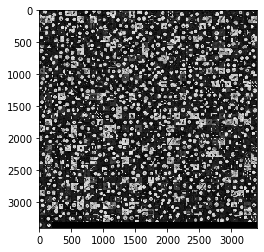

In [34]:
plt.imshow(sprite)

In [35]:
# 拜讀 

In [36]:
# NxHxW[x3]
img_npy.shape

(1124, 100, 100, 3)

In [37]:
len(img_npy.shape)

4

In [38]:
img_npy.shape[:]

(1124, 100, 100, 3)

In [39]:
img_npy.reshape((img_npy.shape[0], -1))

array([[ 58.615  ,  58.615  ,  58.615  , ...,  42.795  ,  42.795  ,
         42.795  ],
       [ 68.     ,  68.     ,  68.     , ..., 101.     , 101.     ,
        101.     ],
       [ 39.     ,  39.     ,  39.     , ...,  46.     ,  46.     ,
         46.     ],
       ...,
       [ 62.2816 ,  62.2816 ,  62.2816 , ...,  92.19432,  92.19432,
         92.19432],
       [ 33.     ,  33.     ,  33.     , ...,  70.     ,  70.     ,
         70.     ],
       [ 52.     ,  52.     ,  52.     , ...,  50.     ,  50.     ,
         50.     ]], dtype=float32)

In [40]:
img_npy.shape[:]

(1124, 100, 100, 3)

In [41]:
np.min(img_npy.reshape((img_npy.shape[0], -1)), axis=1)

array([39.795   , 27.      , 24.      , ..., 26.919922, 18.      ,
       24.      ], dtype=float32)

In [47]:
#transpose
arr = np.arange(9).reshape((3,3))
arr

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [50]:
np.transpose(arr)

array([[0, 3, 6],
       [1, 4, 7],
       [2, 5, 8]])

In [ ]:
#====================================================================================================#

In [ ]:
#====================================================================================================#

## 3+. sprite image (with py way)

https://github.com/evaliyev/tf-embedding-visualization-demo/blob/master/main.py

witout the normalization: The method2 has about 1.65 times faster than "def images_to_sprite(data)"

- def images_to_sprite(data): 1.1 s
- def tfdsimg_to_sprite: 658 ms

The key is the code is simple and readable!

In [136]:
%%time

# about thumbnail image's size
# currently, TB support maximum dimensions 8192x8192 px. One has to control proper thumbnail_size.
# ex: sqrt(len(val_imgs) * thumbnail_size(w or h) must < 8192
# so, it will need some resize : 1. resize your thumbnail. 2. resize the final sprite less 8192


# extract tf.ds.img to a list of tensors
img_data=[]
for image_batch, label_batch in val_ds_pre: 
    [img_data.append(x) for x in image_batch] # same as: for i in range(BATCH_SIZE):

CPU times: user 915 ms, sys: 1.24 s, total: 2.16 s
Wall time: 824 ms


In [137]:
# check data

#img_data[0]

"""
<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[40., 40., 40.],
        [45., 45., 45.],
        [42., 42., 42.],"""


# tf.shape(img_data)
"""
<tf.Tensor: shape=(4,), dtype=int32, numpy=array([1124,  100,  100,    3], dtype=int32)>"""

# tf.shape(img_data[0])
"""
<tf.Tensor: shape=(3,), dtype=int32, numpy=array([100, 100,   3], dtype=int32)>"""


# img_w_h_c  = (img_data[0].shape[0], img_data[0].shape[1], img_data[0].shape[2])
"""
(100, 100, 3)"""

'\n(100, 100, 3)'

In [138]:
%%time

# taken from: https://github.com/evaliyev/tf-embedding-visualization-demo/blob/master/main.py
    
import math

images = img_data.copy()

# have to be tf.uint8 when show in matplotlib
size = int(math.sqrt(len(images))) + 1
while len(images) < size * size:
    images.append(np.zeros((img_width, img_height, 3), dtype=np.uint8))
rows = []
for i in range(size):
    rows.append(tf.concat(images[i * size:(i + 1) * size], 1))

# concat all rows to tile
# the tf tensor Ops output is float,
# then convert tensors(float) to np arrray with data type unit8
img_data_tile = tf.concat(rows, 0).numpy().astype(np.uint8)

cv2.imwrite(os.path.join(log_dir, 'sprite_4_classes_methd2.png'), img_data_tile)

CPU times: user 448 ms, sys: 74.3 ms, total: 522 ms
Wall time: 535 ms


True

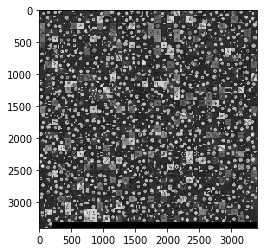

In [139]:
plt.imshow(img_data_tile)

In [32]:
# tf.concat(rows, 0) issue
InvalidArgumentError: cannot compute ConcatV2 as input #27(zero-based) was expected to be a float tensor but is a uint8 tensor [Op:ConcatV2] name: concat
      
# It is caused by the inputs have two different dtypes: float32 and float64.   

SyntaxError: invalid syntax (<ipython-input-32-999d0fe0f3c0>, line 1)

## 3++. sprite image (with py way and refined)

#### 構想如何判斷是否為平方根

note: python 3.8以後，已支援is_sqrt func.

In [140]:
%%time

# about thumbnail image's size
# currently, TB support maximum dimensions 8192x8192 px. One has to control proper thumbnail_size.
# ex: sqrt(len(val_imgs) * thumbnail_size(w or h) must < 8192
# so, it will need some resize : 1. resize your thumbnail. 2. resize the final sprite less 8192


# extract tf.ds.img to a list of tensors
img_data=[]
for image_batch, label_batch in val_ds_pre: 
    [img_data.append(x.numpy().astype(np.uint8)) for x in image_batch] # same as: for i in range(BATCH_SIZE):

CPU times: user 420 ms, sys: 181 ms, total: 600 ms
Wall time: 374 ms


In [141]:
"""
When 1124 images in ds, sqrt as 33, +1 to 34X34 array as 1156.
Fill the

"""

# check number is sqrt or not
x = 1124
if x >= 0 and x ** 0.5 == int(x ** 0.5):
    print('sqrt', x ** 0.5, int(x ** 0.5))
else:
    print('not the sqrt', x ** 0.5, int(x ** 0.5))

not the sqrt 33.52610922848042 33


#### 請同學精簡為function

In [142]:
def is_sqrt(x):
    if x >= 0 and x ** 0.5 == int(x ** 0.5):
        return 0
    else:
        return 1

In [143]:
# todo:目前寫法只能處理uni，其他dataset會顯示float not uint8問題。

import math

def tfdsimg_to_sprite(img_data):
    data_length = len(img_data)
    root_add_1 = is_sqrt(data_length)
    
    # get sprite size N, of (NxN)
    sprite_size = int(math.sqrt(data_length)) + root_add_1 # todo: 處理整除時的判斷，+1會分別多一行一列。
    
    # append black pad to fill the vacancy
    while len(img_data) < sprite_size ** 2:
        img_data.append(np.zeros((img_width, img_height, 3), np.uint8))
    
    rows = []
    for i in range(sprite_size):
        rows.append(tf.concat(img_data[i * sprite_size:(i + 1) * sprite_size], 1))
        #每次從img_data中擷取一份sprite_sizet長度的內容貼上
            
    # concat all rows
#     img_data_tile = tf.concat(rows, 0)
    img_data_tile = tf.concat(rows, 0).numpy().astype(np.uint8)
      
    print("squre size:", sprite_size, sprite_size ** 2)
    
    return img_data_tile



In [144]:
%%time
sprite_image = []
sprite_image = tfdsimg_to_sprite(img_data)


cv2.imwrite(os.path.join(log_dir, 'sprite_4_classes_methd2++.png'), sprite_image)
    
# 檔案較小22 -> 19.3MB，對比變低，應該是轉換int時改變了。

squre size: 34 1156
CPU times: user 444 ms, sys: 38.7 ms, total: 483 ms
Wall time: 462 ms


True

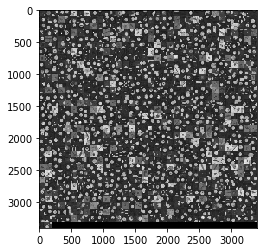

In [145]:
plt.imshow(sprite_image)

### add the missed Histogram equalization for better viewing 

In [ ]:
import cv2

# equ = cv2.equalizeHist(img_data_tile)# only for gray image

R, G, B = cv2.split(img_data_tile)

output1_R = cv2.equalizeHist(R)
output1_G = cv2.equalizeHist(G)
output1_B = cv2.equalizeHist(B)

equ = cv2.merge((output1_R, output1_G, output1_B))


In [ ]:
equ.shape

In [ ]:
cv2.imwrite(os.path.join(log_dir, 'sprite_4_classes_methd3_equ_1.jpg'), equ)

In [ ]:
plt.imshow(equ)
"""it looks petty bad."""

#### note: here is tesnor and tf.unint8 not np@

In [ ]:
img_data_tile.shape

In [ ]:
img_data_tile.dtype

In [ ]:
img_data_tile[0,0,:]

In [ ]:
"""TypeError: Expected Ptr<cv::UMat> for argument 'img'
cv2 expect 'amg' is a np.array, not the tf.tensor!
"""
cv2.imwrite(os.path.join(log_dir, 'sprite_4_classes_methd2.jpg'), img_data_tile.numpy())